In [1]:
import os
import json
from collections import deque
from typing import Dict, List, Optional, Any, Union

from langchain_openai import ChatOpenAI


# Get human objective
# refine it via human in the loop and via adding context (short/long term memory search) -> the output is a json dict of the design
# build the modules and test benches usiiing short and long term memory

In [2]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["SERPAPI_API_KEY"] = os.getenv("SERPAPI_API_KEY")

In [3]:
llm = ChatOpenAI(model='gpt-3.5-turbo-0125', temperature=0)
bigllm = ChatOpenAI(model='gpt-4-0125-preview', temperature=0)

# Context for FFT

In [4]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# FFT docs 
url = """https://www.fpga4student.com/2017/04/verilog-code-for-16-bit-risc-processor.html"""#"""https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm"""
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Add 
#docs.extend([*docs_pydantic, *docs_sq])

# Sort the list based on the URLs in 'metadata' -> 'source'
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

# Concatenate the 'page_content' of each sorted dictionary
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

In [5]:
len(concatenated_content)

26736

# Requirement extraction chain

In [6]:
from FPGA_AGI.chains import RequirementChain

requirement_chain = RequirementChain.from_llm(bigllm)

requirements = requirement_chain.invoke(
    {"objective": "design an 8-bit RISC V processor in system verilog", #"design a 32 bit 16-point FFT to run on an ultra-96 v2 FPGA board. the language must be system verilog.",
     "context" : concatenated_content}
)

type(requirements)

FPGA_AGI.chains.Requirements

In [7]:
import pprint
pprint.pprint(requirements.goals)
pprint.pprint(requirements.requirements)

['Design an 8-bit RISC V processor using SystemVerilog.']
['1. The processor must be designed based on the RISC V instruction set and '
 'should follow a Harvard-type data path structure.',
 '2. Implement memory access instructions including Load Word (LD) and Store '
 'Word (ST) with the specified operations.',
 '3. Implement data processing instructions including Add (ADD), Subtract '
 '(SUB), Invert (INV), Logical Shift Left (LSL), Logical Shift Right (LSR), '
 'Bitwise AND (AND), Bitwise OR (OR), and Set on Less Than (SLT) with the '
 'specified operations.',
 '4. Implement control flow instructions including Branch on Equal (BEQ), '
 'Branch on Not Equal (BNE), and Jump (JMP) with the specified operations.',
 '5. Design the processor control unit to generate appropriate control signals '
 'for each instruction type.',
 '6. Design the ALU control unit to generate the correct ALU operation based '
 'on the ALUOp signal and the opcode.',
 '7. Implement instruction memory, data memory

# Modular design agent

In [9]:
from FPGA_AGI.tools import search_web, python_run, Thought
from langchain_community.tools.tavily_search import TavilySearchResults, TavilyAnswer
from FPGA_AGI.agents import HierarchicalDesignAgent

#gpt-4-0125-preview
model = ChatOpenAI(model='gpt-4-1106-preview', temperature=0, streaming=True)

tools = [search_web]

agent = HierarchicalDesignAgent(model, tools)

hierarchical_response = agent.invoke(requirements.goals, requirements.requirements)

Thought
search_web
Thought
Thought


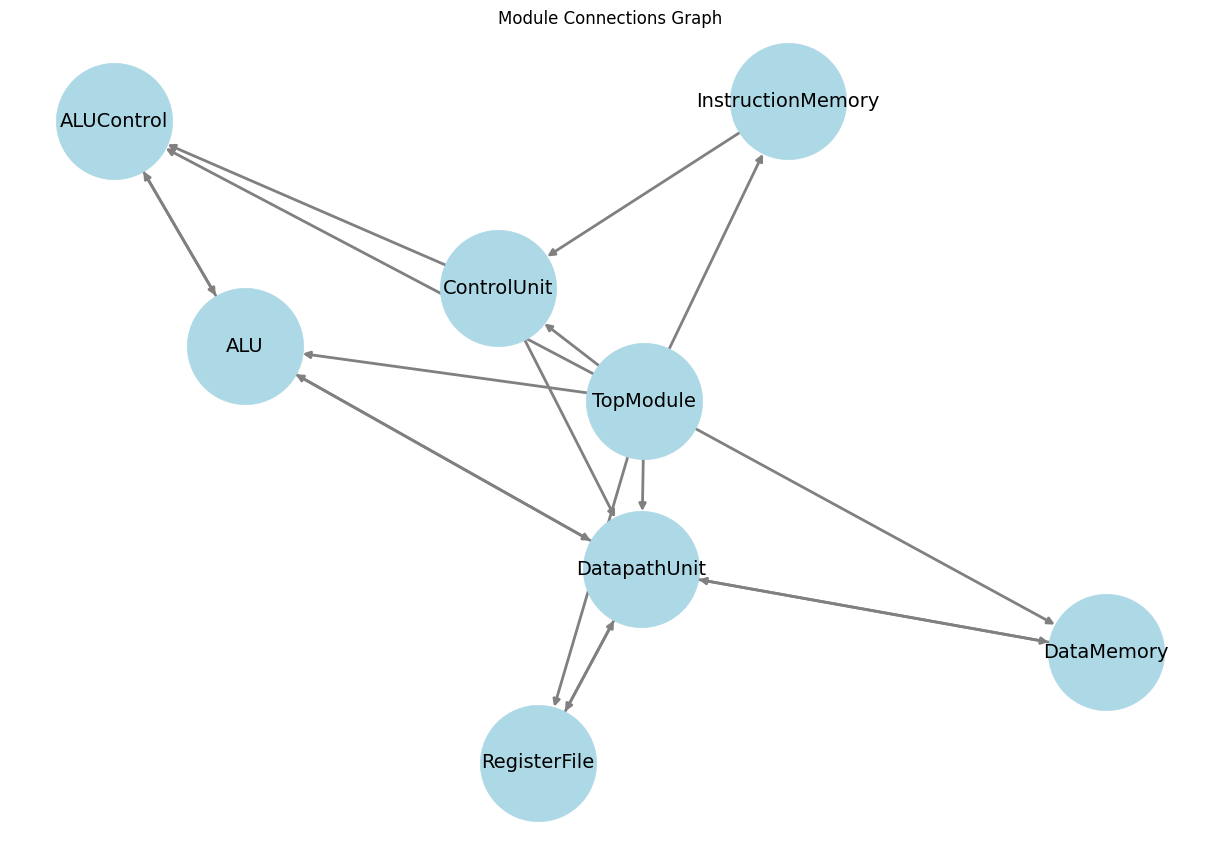

In [14]:
from FPGA_AGI.utils import plot_graph

plot_graph(hierarchicalmodules = hierarchical_response, save_path = None)

In [12]:
hierarchical_response.graph

[Module(name='TopModule', description='Top-level module for the 8-bit RISC V processor. It encapsulates all the sub-modules and interconnects them according to the Harvard architecture.', connections=['ControlUnit', 'DatapathUnit', 'InstructionMemory', 'DataMemory', 'RegisterFile', 'ALU', 'ALUControl'], ports=['clk', 'reset'], notes='This is the top hierarchy module. All sub-modules are instantiated here and connected appropriately.'),
 Module(name='ControlUnit', description='Generates control signals for the processor based on the current instruction.', connections=['DatapathUnit', 'ALUControl'], ports=['instruction[15:0]', 'control_signals'], notes='Decodes the instruction to generate signals like RegWrite, ALUSrc, MemtoReg, etc.'),
 Module(name='DatapathUnit', description='Manages the data flow within the processor, including the ALU, register file, and memory access.', connections=['ALU', 'RegisterFile', 'DataMemory'], ports=['data_in', 'data_out', 'alu_result', 'control_signals'],

# counting how many times the agent fails out of 10 repeats
failure = 0
outputs = []
for i in range(10):
    try:
        output = app.invoke(inputs)
        out = json.loads(output['messages'][-1].additional_kwargs["function_call"]["arguments"])
        outputs.append(out)
    except:
        failure += 1

print(f'Failed {failure} times out of 10 runs.')
out['graph']

from openai import OpenAI
client = OpenAI()
import json
from tqdm import tqdm

l = {}
for T in tqdm(range(0, 11)):
    response = client.chat.completions.create(
    model="gpt-3.5-turbo-0125",
    messages=[
        {
        "role": "system",
        "content": "You will be provided with a high level idea of a hardware. come up with a list of modules that such a hardware needs. only come up with a list of names."
        },
        {
        "role": "user",
        "content": "We want to build a competitor to GPU based on conventional logic. We want this new tool to beat GPUs for AI applications."
        }
    ],
    temperature=T*0.2,
    max_tokens=400,
    top_p=1
    )
    l[f'idea_{T}'] = {'T': T*0.2, 'content': response.choices[0].message.content}

out_file = open("test_gpt_3.5.json", "w") 
  
json.dump(l, out_file, indent = 6) 
  
out_file.close() 